**Parcours Ingénieur Machine Learning**<br>
**Plus d'informations** : https://openclassrooms.com/fr/paths/148-ingenieur-machine-learning <br>

**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 31/07/2022<br>
**Accès projet git** : https://github.com/viczer/P6-Openclassroom-Classez-des-images-Deep-Learning

---


<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h2 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Project 6 : Classez des images à l'aide d'algorithmes de Deep Learning
 </br>  | Notebook 1_0 : Exploration dataset, preprocessing | <br></h2> </div>    

<div style="display: flex; background: rgb(75,0,130);
background: linear-gradient(90deg, rgba(75,0,130,1) 47%, rgba(216,191,216,1) 89%, rgba(230,230,250,1) 100%);">
<h4 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center"> </h4> 
</div>    

---
# 1. Contexte

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Vous vous demandez donc ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc obtenir un algorithme capable de classer les images en fonction de la race du chien présent sur l'image.

## Les données
Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous entraînerez votre algorithme en utilisant le Stanford Dogs Dataset.

## Mission
L'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

Vous avez peu d’expérience sur le sujet, vous décidez donc de contacter un ami expert en classification d’images.

Il vous conseille dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).

Ensuite, il vous incite à mettre en œuvre deux approches s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels), que vous comparerez en termes de temps de traitement et de résultat :

* Une première en réalisant votre propre réseau CNN, en vous inspirant de réseaux CNN existants. Prenez soin d'optimiser certains hyperparamètres (des layers du modèle, de la compilation du modèle et de l’exécution du modèle)
* Une deuxième en utilisant le transfer learning, c’est-à-dire en utilisant un réseau déjà entraîné, et en le modifiant pour répondre à votre problème.

Concernant le transfer learning, votre ami vous précise que :

* Une première chose obligatoire est de réentraîner les dernières couches pour prédire les classes qui vous intéressent seulement.
* Il est également possible d’adapter la structure (supprimer certaines couches, par exemple) ou de réentraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.

## Ressources de calcul
Votre ami vous alerte sur le fait que l'entraînement (même partiel) d'un réseau de neurones convolutionnels est très gourmand en ressources. Si le processeur de l’ordinateur un peu ancien de l’association ne suffit pas, il vous propose plusieurs solutions :

* Limitez le jeu de données, en ne sélectionnant que quelques classes (races de chiens), ce qui permettra déjà de tester la démarche et la conception des modèles, avant une éventuelle généralisation.
* Utilisez la carte graphique de l’ordinateur en tant que GPU (l'installation est un peu fastidieuse, et l'ordinateur est inutilisable le temps du calcul).

Dans ce notebook, je vais explorer les photos les races, et faire quelques essais de traitement d'images, que je pourrais utiliser ou non pour les algorithmes de prédictions.

In [24]:
import glob
import os

import pandas as pd
import numpy as np

from matplotlib.image import imread
import matplotlib.pyplot as plt

from skimage import color, exposure, img_as_ubyte
from skimage.filters import try_all_threshold
from skimage.restoration import denoise_tv_chambolle
from skimage.transform import resize

from skimage.io import imsave

from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator


# Les fonctions

In [ ]:

def resize_h220(img, ratio):
    ratio = ratio
    width = 220
    height = round(width * ratio, 0)

    return resize(img, (height, width), anti_aliasing=True)


def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()


def rgb_color(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original')
    ax[0, 0].axis('off')

    ax[0, 1].hist(red.ravel(), bins=256, color='red')
    ax[0, 1].set_title('Red histogram')

    ax[1, 0].hist(green.ravel(), bins=256, color='green')
    ax[1, 0].set_title('Blue histogram')

    ax[1, 1].hist(blue.ravel(), bins=256, color='blue')
    ax[1, 1].set_title('Green histogram')

    plt.subplots_adjust()
    plt.show()


def compare_img(original, transformed, title_orignal='Original',
                title_transformed='Transformed',
                cmap_result='gray', filename=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].imshow(original, cmap=cmap_result)
    ax[0].set_title(title_orignal)
    ax[0].axis('off')

    ax[1].imshow(transformed, cmap=cmap_result)
    ax[1].set_title(title_transformed)
    ax[1].axis('off')

    plt.subplots_adjust()
    plt.savefig('./img/preprocess_image_' + filename + '.png', transparent=True)
    plt.show()


def transform_image(original, classes=3, cmap_result='gray', filename=None):
    thresholds = threshold_multiotsu(original, classes=classes)
    regions = np.digitize(original, bins=thresholds)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title('Grayscale')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(original.ravel(), bins=255)
    ax[1].set_title('Histogram')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap=cmap_result)
    ax[2].set_title(str(classes) + ' gray levels')
    ax[2].axis('off')

    plt.subplots_adjust()
    plt.savefig('./img/preprocess_image_' + filename + '_' + str(classes) + 'classes.png', transparent=True)
    plt.show()


def features(image, extractor):
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors


---
# 2. Création du dataframe

In [25]:
# Je récupère les uri de chaque image
dogs_lst = []
for file in glob.glob('src\img\*\*.jpg'):
    dogs_lst.append(file)

# Je stocke dans un dataframe
dogs = pd.DataFrame(dogs_lst, columns=['uri'])

# Je récupère les noms de fichiers
dogs['filename'] = dogs['uri'].str.split('\\').str.get(3)

# J'extrais la race
dogs['breeds'] = dogs.uri.str.split('\\').str.get(2).str.slice(10)

# Je récupère le format de la photo
dogs['shape'] = dogs.uri.apply(lambda x: imread(x).shape)

# Je récupère les ratios des images
dogs['ratio'] = dogs['shape'].str.get(0) / dogs['shape'].str.get(1)

dogs

,uri,filename,breeds,shape,ratio
0,src\img\n02085620-Chihuahua\n02085620_10074.jpg,n02085620_10074.jpg,Chihuahua,"(500, 333, 3)",1.501502
1,src\img\n02085620-Chihuahua\n02085620_10131.jpg,n02085620_10131.jpg,Chihuahua,"(495, 395, 3)",1.253165
2,src\img\n02085620-Chihuahua\n02085620_10621.jpg,n02085620_10621.jpg,Chihuahua,"(298, 500, 3)",0.596000
3,src\img\n02085620-Chihuahua\n02085620_1073.jpg,n02085620_1073.jpg,Chihuahua,"(500, 345, 3)",1.449275
4,src\img\n02085620-Chihuahua\n02085620_10976.jpg,n02085620_10976.jpg,Chihuahua,"(484, 322, 3)",1.503106
...,...,...,...,...,...
20575,src\img\n02116738-African_hunting_dog\n0211673...,n02116738_9798.jpg,African_hunting_dog,"(375, 500, 3)",0.750000
20576,src\img\n02116738-African_hunting_dog\n0211673...,n02116738_9818.jpg,African_hunting_dog,"(333, 500, 3)",0.666000
20577,src\img\n02116738-African_hunting_dog\n0211673...,n02116738_9829.jpg,African_hunting_dog,"(300, 202, 3)",1.485149
20578,src\img\n02116738-African_hunting_dog\n0211673...,n02116738_9844.jpg,African_hunting_dog,"(400, 600, 3)",0.666667


In [26]:
print(f'Nous avons {len(dogs)} photos de chiens comprenant {dogs.breeds.nunique()} races.')

Nous avons 20580 photos de chiens comprenant 120 races.


---
# 3. Réduction de la taille des images

## 3.1 - Vérification des couches de couleurs

In [32]:
dogs['shape'].str.get(2).reset_index().groupby('shape').count()

,index
shape,
3,20579


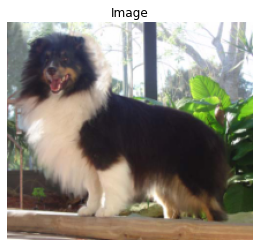

In [28]:
idx = dogs[dogs['shape'].str.get(2) == 4].index[0]
show_image(imread(dogs.uri[idx]))

Nous avons une image avec une couche alpha en plus du RGB. Je la retire du jeu de donnée, car théoriquement incompatible avec le format jpg.

In [33]:
dogs = dogs[dogs['shape'].str.get(2) != 4]
dogs = dogs.reset_index(drop=True)
dogs['shape'].str.get(2).reset_index().groupby('shape').count()

,index
shape,
3,20579


## 3.2 - Vérification de la qualité

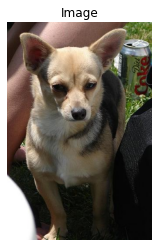

(500, 333, 3)

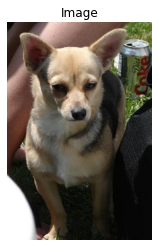

(330, 220, 3)

In [34]:
idx = 0
img = imread(dogs.uri[idx])
show_image(img)
display(img.shape)
img220 = resize_h220(img, dogs.ratio[idx])
show_image(img220)

display(img220.shape)

## 3.3 - Exécution de la réduction

In [36]:
# Exécuté 1 seule fois pour la création des images

for i in range(len(dogs)):
    path = 'src\img220\\' + dogs.breeds[i] + '\\'
    if os.path.isfile(path + dogs.filename[i]) is False:
         img = imread(dogs.uri[i])
         img220 = resize_h220(img, dogs.ratio[i])
        
         if os.path.isdir(path) is False:
             os.mkdir(path)
         imsave(path + dogs.filename[i], img_as_ubyte(img220))


## 3.4 - Vérification des transformations

In [37]:
# Je récupère les uri de chaque image
dogs220_lst = []
for file in glob.glob('src\img220\*\*.jpg'):
    dogs220_lst.append(file)

# Je stocke dans un dataframe
dogs220 = pd.DataFrame(dogs220_lst, columns=['uri'])

# J'extrais la race
dogs220['breeds'] = dogs220.uri.str.split('\\').str.get(2)

# Je récupère le format de la photo
dogs220['shape'] = dogs220.uri.apply(lambda x: imread(x).shape)

dogs220

,uri,breeds,shape
0,src\img220\affenpinscher\n02110627_10147.jpg,affenpinscher,"(196, 220, 3)"
1,src\img220\affenpinscher\n02110627_10185.jpg,affenpinscher,"(202, 220, 3)"
2,src\img220\affenpinscher\n02110627_10225.jpg,affenpinscher,"(165, 220, 3)"
3,src\img220\affenpinscher\n02110627_10437.jpg,affenpinscher,"(165, 220, 3)"
4,src\img220\affenpinscher\n02110627_10439.jpg,affenpinscher,"(165, 220, 3)"
...,...,...,...
20574,src\img220\Yorkshire_terrier\n02094433_96.jpg,Yorkshire_terrier,"(176, 220, 3)"
20575,src\img220\Yorkshire_terrier\n02094433_9618.jpg,Yorkshire_terrier,"(165, 220, 3)"
20576,src\img220\Yorkshire_terrier\n02094433_962.jpg,Yorkshire_terrier,"(330, 220, 3)"
20577,src\img220\Yorkshire_terrier\n02094433_967.jpg,Yorkshire_terrier,"(147, 220, 3)"


In [38]:
print(f'Nous avons {len(dogs220)} photos de chiens comprenant {dogs220.breeds.nunique()} races. Les réductions sont validées')

Nous avons 20579 photos de chiens comprenant 120 races. Les réductions sont validées


Cette opération a en moyenne réduit le poids des photos par 4. Nous économiserons du temps de calcul.

---
# 4. Différents tests de transformation d'image 
## 4.1 - Réduction du bruit

In [39]:
img = imread(dogs.uri.loc[0])

***************************

C:\Users\victo\AppData\Local\Temp\ipykernel_17496\1923027340.py:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_img = denoise_tv_chambolle(img, weight=0.1, multichannel=True)


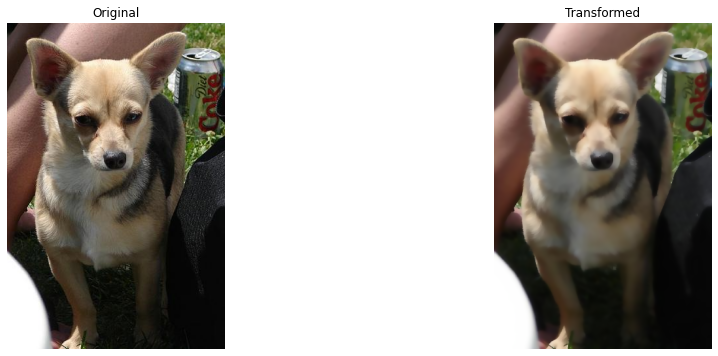

In [41]:
denoised_img = denoise_tv_chambolle(img, weight=0.1, multichannel=True)
compare_img(img, denoised_img, filename='denoised')

## 4.2 - Passage en N&B

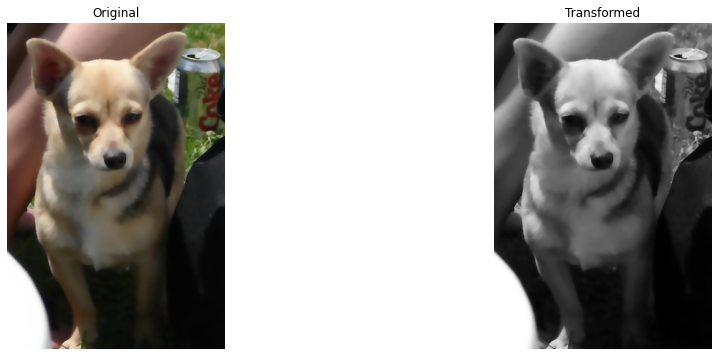

In [42]:
gray_img = color.rgb2gray(denoised_img)
compare_img(denoised_img, gray_img, filename='gray')

## 4.3 - Egaliseur

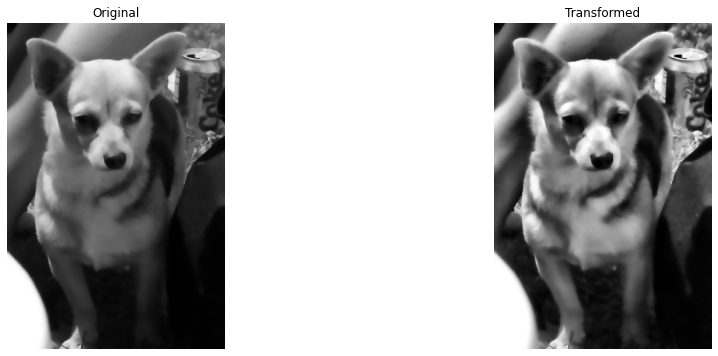

In [43]:
gray_img_eq = exposure.equalize_adapthist(gray_img)
compare_img(gray_img, gray_img_eq, filename='equalize')

## 4.4 - Application de seuils de niveaux de gris

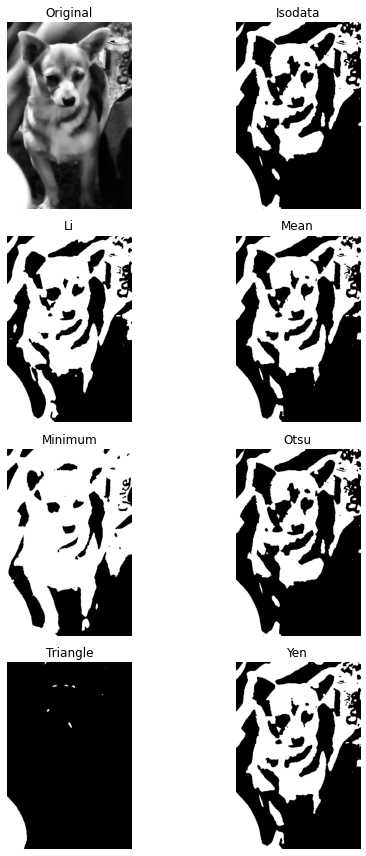

In [44]:
fig, ax = try_all_threshold(gray_img_eq, figsize=(8, 12), verbose=False)
plt.savefig('./img/preprocess_image_alltreshold.png', transparent=True)
plt.show()

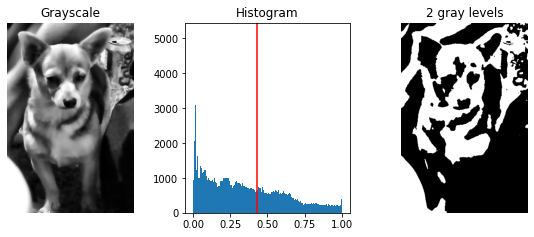

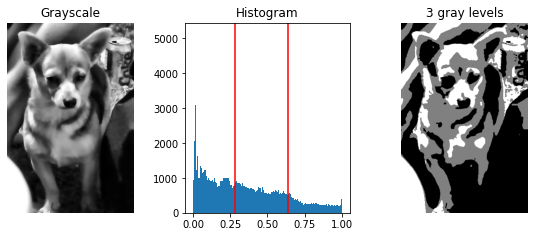

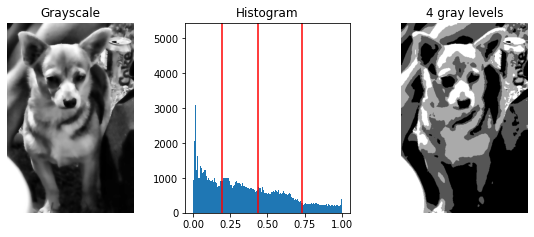

In [45]:
classes = [2, 3, 4]
for cl in classes:
    transform_image(gray_img_eq, cl, filename="level_gray")

---
# 5. Data Augmentation

Cette technique modifie une photo aléatoire. Nous l'utilisons de manière à ce qu'un algorithme ne voit pas 2 fois la même photo, lors de plusieurs epoch lors de l'entraînement d'un réseau CNN.

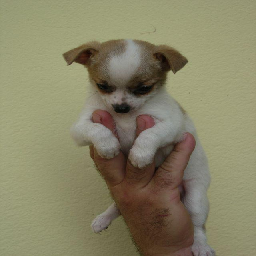

In [49]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

img = load_img(dogs.uri[27], target_size=(256, 256))
img

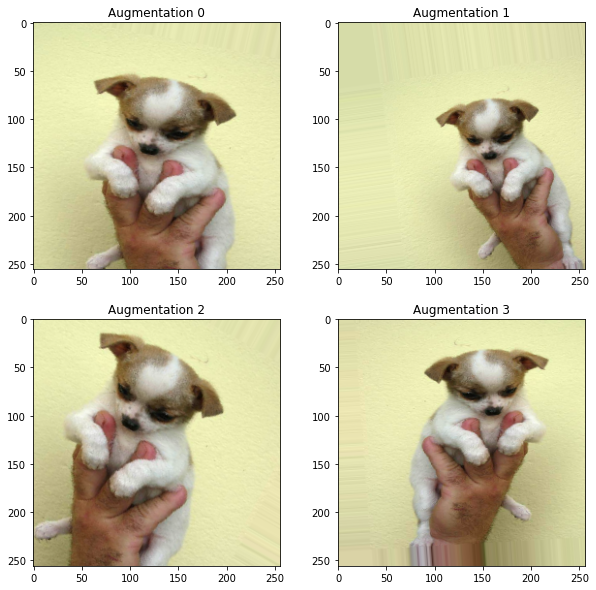

In [59]:
from keras.utils import load_img
from keras.utils import img_to_array
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
get_img_aug(img, train_datagen)

---
# 6. Export CSV

In [ ]:
dogs[['uri', 'breeds']].to_csv('src/dogs.csv', index=False)
dogs220[['uri', 'breeds']].to_csv('src/dogs220.csv', index=False)